# Example 1: Function Fitting

In this example, we will cover how to leverage grid refinement to maximimze KANs' ability to fit functions

intialize model and create dataset

In [1]:
from kan import *

# initialize KAN with G=3
model = KAN(width=[2,1,1], grid=3, k=3)

# create dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2,ranges = [-3,3])

Train KAN (grid=3)

In [2]:
model.train(dataset, opt="LBFGS", steps=200);

train loss: 6.38e+02 | test loss: 9.34e+02 | reg: 1.62e+02 : 100%|█| 200/200 [00:27<00:00,  7.38it/s


The loss plateaus. we want a more fine-grained KAN!

In [3]:
# initialize a more fine-grained KAN with G=10
model2 = KAN(width=[2,1,1], grid=10, k=3)
# initialize model2 from model
model2.initialize_from_another_model(model, dataset['train_input']);

Train KAN (grid=10)

In [4]:
model2.train(dataset, opt="LBFGS", steps=200);

train loss: 3.60e+02 | test loss: 7.01e+02 | reg: 1.97e+02 : 100%|█| 200/200 [00:31<00:00,  6.28it/s


The loss becomes lower. This is good! Now we can even iteratively making grids finer.

In [5]:
grids = np.array([5,10,20,50,100])

train_losses = []
test_losses = []
steps = 500
k = 3

for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2,1,1], grid=grids[i], k=k)
    if i != 0:
        model = KAN(width=[2,1,1], grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])
    results = model.train(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=300)
    train_losses += results['train_loss']
    test_losses += results['test_loss']
    

train loss: 2.22e+02 | test loss: 3.79e+02 | reg: 6.45e+03 : 100%|█| 500/500 [01:12<00:00,  6.93it/s
train loss: 2.20e+01 | test loss: 5.78e+01 | reg: 1.34e+04 : 100%|█| 500/500 [01:09<00:00,  7.21it/s
train loss: 1.05e+00 | test loss: 5.89e+00 | reg: 1.34e+04 : 100%|█| 500/500 [01:03<00:00,  7.90it/s
train loss: 1.76e-01 | test loss: 3.49e+01 | reg: 1.34e+04 : 100%|█| 500/500 [02:00<00:00,  4.16it/s
train loss: 7.61e-02 | test loss: 6.21e+02 | reg: 1.35e+04 : 100%|█| 500/500 [02:01<00:00,  4.10it/s


Training dynamics of losses display staircase structures (loss suddenly drops after grid refinement)

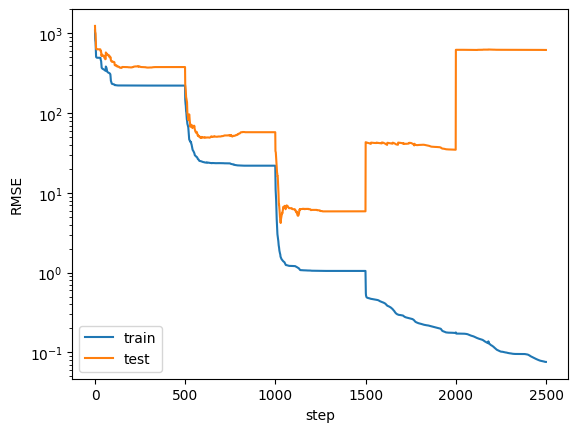

In [6]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

Neural scaling laws

Text(0, 0.5, 'RMSE')

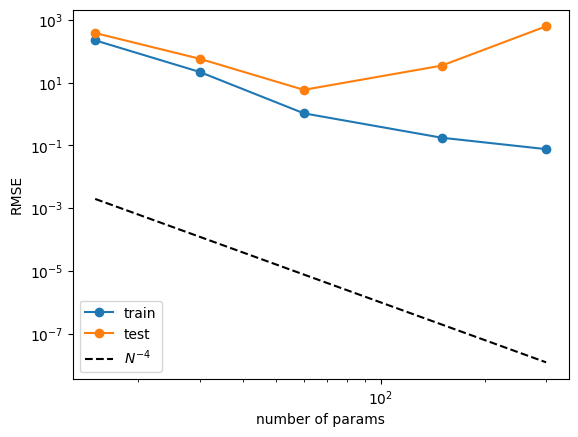

In [7]:
n_params = 3 * grids
train_vs_G = train_losses[(steps-1)::steps]
test_vs_G = test_losses[(steps-1)::steps]
plt.plot(n_params, train_vs_G, marker="o")
plt.plot(n_params, test_vs_G, marker="o")
plt.plot(n_params, 100*n_params**(-4.), ls="--", color="black")
plt.xscale('log')
plt.yscale('log')
plt.legend(['train', 'test', r'$N^{-4}$'])
plt.xlabel('number of params')
plt.ylabel('RMSE')